# Event Study

_UNDER CONSTRUCTION_


- event study: CAR, BHAR, post-announcement drift (Kolari 2010 and others)
- cross-sectional correlation: cross-correlation, convolution, FFT
- multiple testing: Holm FWER, Benjamin-Hochberg FDR, Bonferroni p-values
- S&P Key Developments

In [1]:

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
from finds.database import SQL
from finds.busday import BusDay
from finds.structured import Benchmarks, Stocks, CRSP, PSTAT
from finds.backtesting import EventStudy
from finds.misc import Show
from secret import credentials, paths, CRSP_DATE
show = Show(ndigits=4, latex=None)
VERBOSE = 0
#
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
keydev = PSTAT(sql, bd, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=None, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
eventstudy = EventStudy(user, bench=bench, stocks=crsp, max_date=CRSP_DATE)
imgdir = paths['images'] / 'events'

Last FamaFrench Date 2023-04-28 00:00:00


## Key developments

In [3]:
# sorted list of all eventids and roleids, provided in keydev class
events = sorted(keydev._event.keys())
roles = sorted(keydev._role.keys())

In [4]:
# str formatter to pretty print descriptions, provided in keydev class
eventformat = lambda e, r: "{event} ({eventid}) {role} [{roleid}]"\
    .format(event=keydev._event[e],
            eventid=e,
            role=keydev._role[r],
            roleid=r) 

## Event study

In [5]:
# event window parameters
left, right, post = -1, 1, 21
end = bd.offset(CRSP_DATE, post - left)
beg = 19890101  # 20020101
minobs = 250

In [6]:
# to lookup prevailing exchange and share codes by permno and date
shrcd = crsp.build_lookup('permno', 'shrcd')
exchcd = crsp.build_lookup('permno', 'exchcd')

# run event study after screening stock universe
def event_pipeline(eventstudy: EventStudy,
                   stocks: Stocks,
                   beg: int,
                   end: int,
                   eventid: int,
                   roleid: int,
                   left: int,
                   right: int,
                   post: int,
                   mincap: float = 300000.) -> DataFrame:
    """helper to merge keydev events and crsp, and screen stock universe"""

    # Retrieve announcement dates for this event
    df = keydev.get_linked(
        dataset='keydev',
        date_field='announcedate',
        fields=['keydevid',
                'keydeveventtypeid',
                'keydevtoobjectroletypeid'],
        where=(f"announcedate >= {beg} "
               f"  and announcedate <= {end}"
               f"  and keydeveventtypeid = {eventid} "
               f"  and keydevtoobjectroletypeid = {roleid}"))\
               .drop_duplicates(['permno', 'announcedate'])\
               .set_index(['permno', 'announcedate'], drop=False)

    # Require in valid screen: 'cap', 'exchcd', 'shcrd'
    stk = stocks.get_many(dataset='daily',
                          permnos=df['permno'],
                          date_field='date',
                          dates=stocks.bd.offset(df['announcedate'], left-1),
                          fields=['prc', 'shrout']).fillna(0)
    df['cap'] = (stk['prc'].abs() * stk['shrout']).values
    df['exchcd'] = [exchcd(row.permno, row.date) for row in stk.itertuples()]
    df['shrcd'] = [shrcd(row.permno, row.date) for row in stk.itertuples()]
    select = (df['cap'].gt(mincap)                  # require cap > $300M
              & df['exchcd'].isin([1, 2, 3])        # primary exchange
              & df['shrcd'].isin([10, 11])).values  # domestic common stocks

    # Call eventstudy to retrieve daily abnormal returns, with named label
    rows = eventstudy(label=f"{eventid}_{roleid}",
                      df=df[select],
                      left=left,
                      right=right,
                      post=post,
                      date_field='announcedate')
    return df.loc[rows.to_records(index=False).tolist()]  # restrict df to rows

__Show subsample plots for selected events__

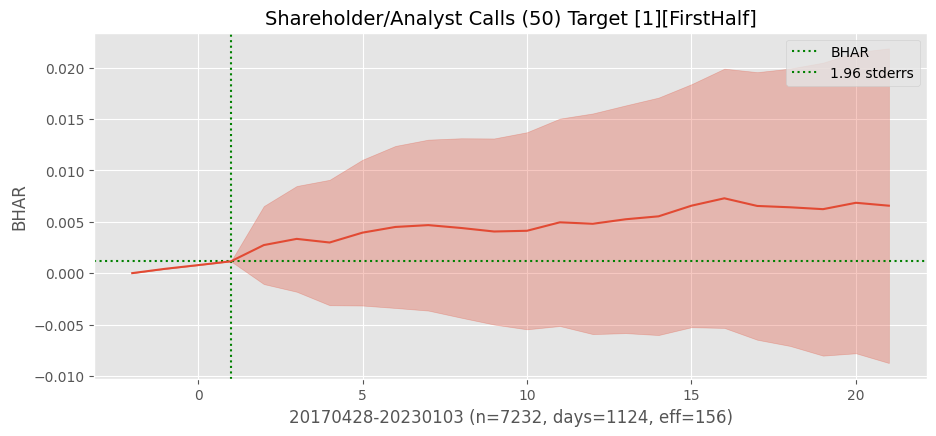

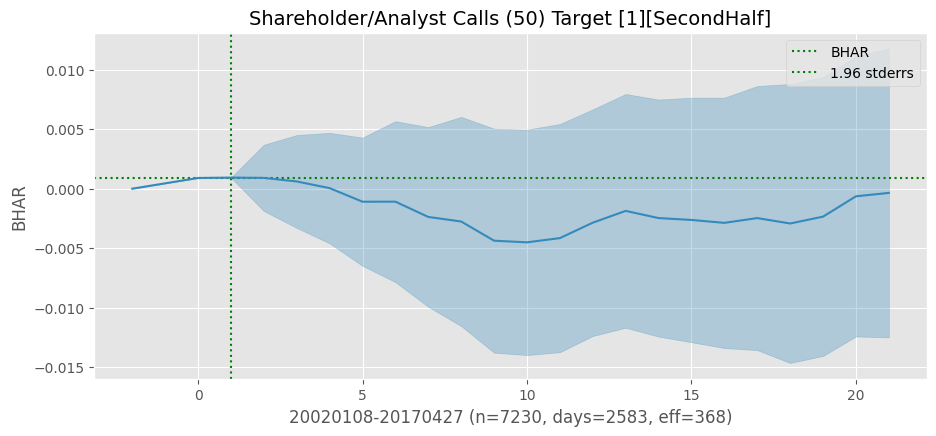

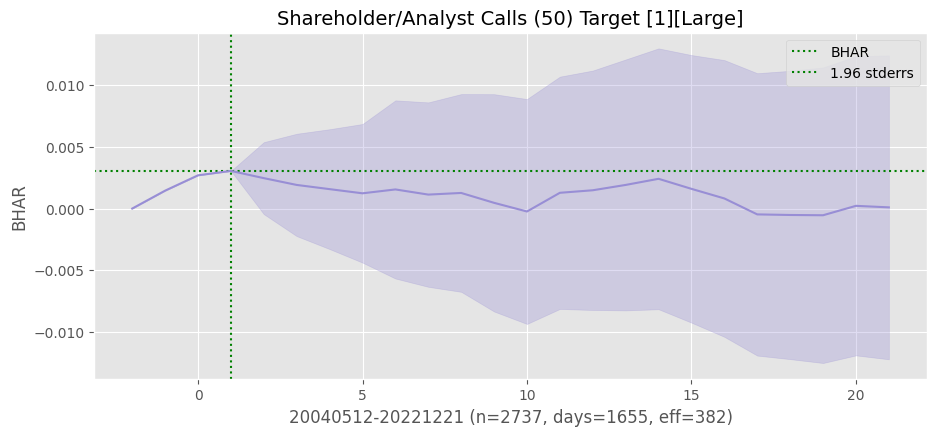

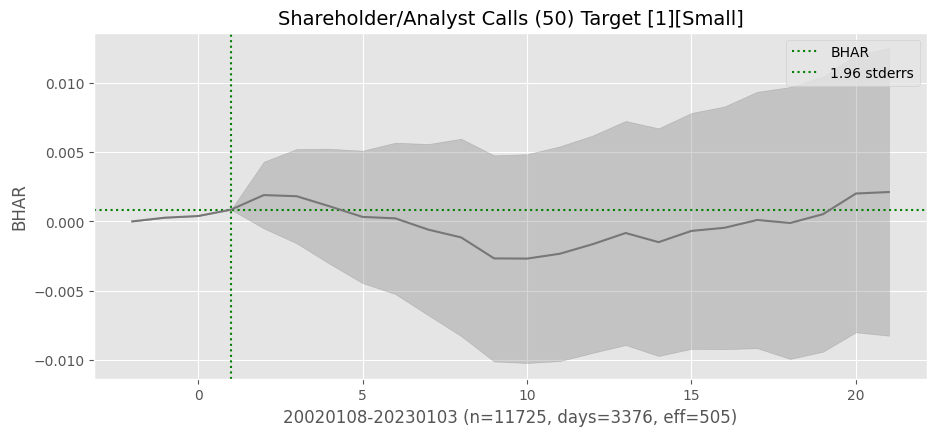

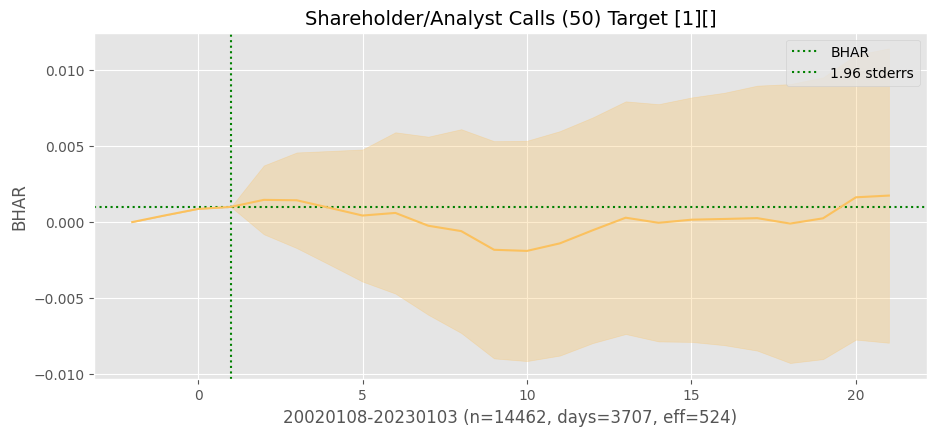

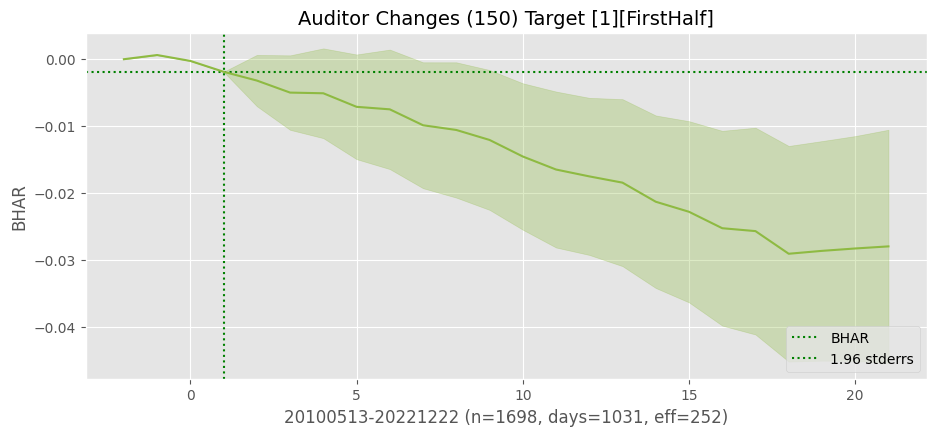

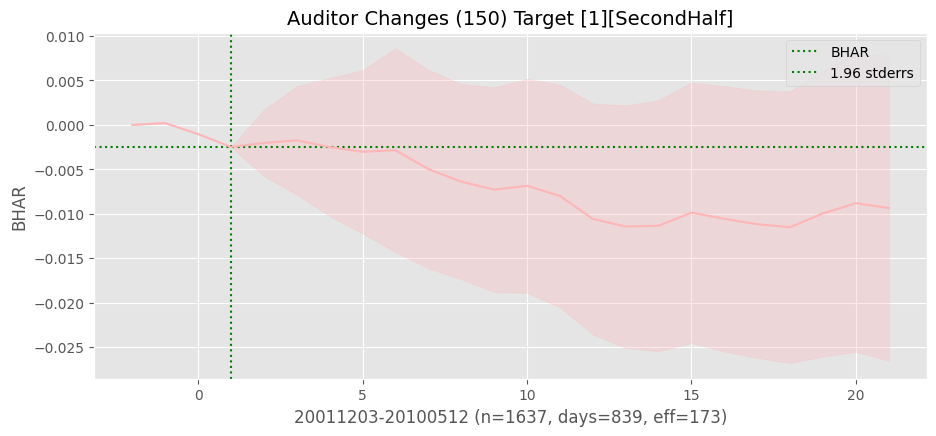

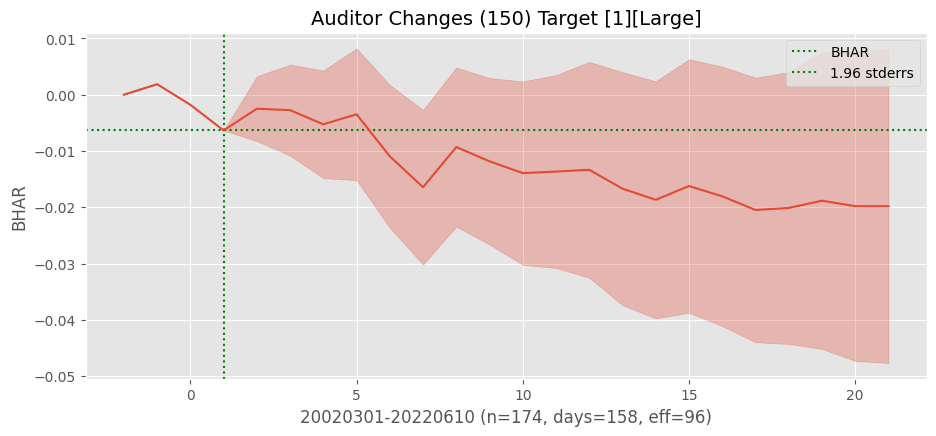

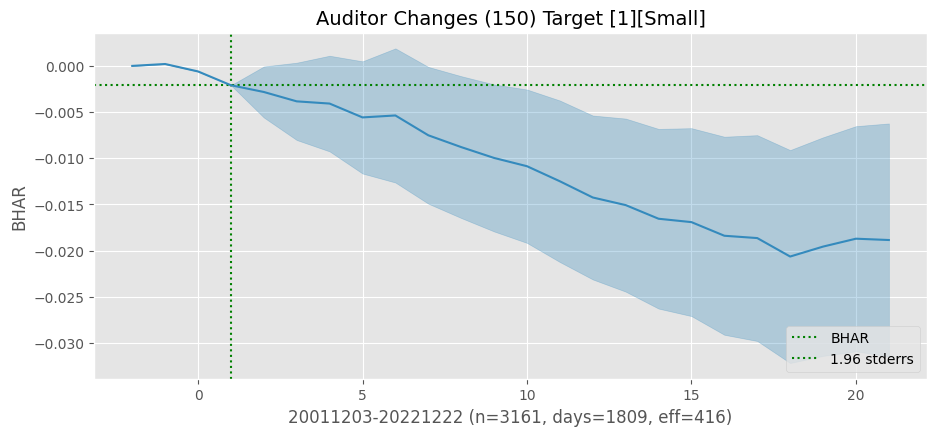

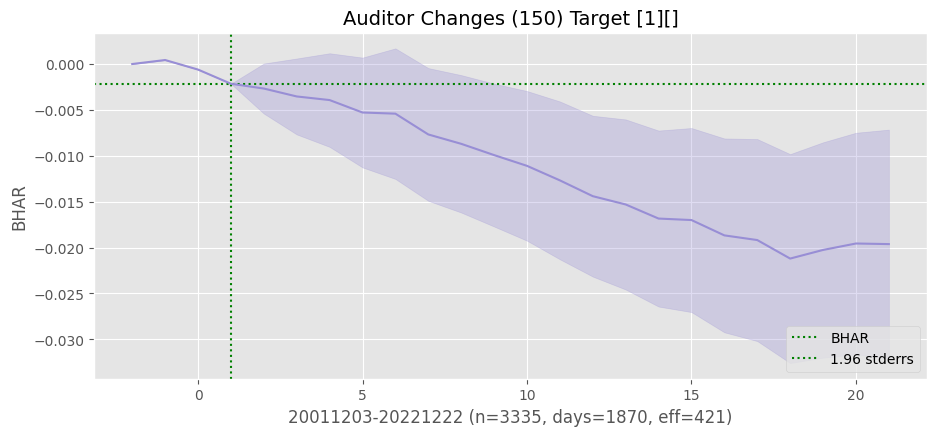

In [7]:
### Show by market cap and half-period
events_list = [[50, 1], [150, 1]]  # top drift
midcap = 20000000   # arbitrary mid market cap breakpoint
for i, (eventid, roleid) in enumerate(events_list):
    #eventid, roleid = 50, 1
    #eventid, roleid = 83, 1
    df = event_pipeline(eventstudy,
                        stocks=crsp,
                        eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'FirstHalf': df['announcedate'].ge(halfperiod).values,
              'SecondHalf': df['announcedate'].lt(halfperiod).values,
              'Large': df['cap'].ge(midcap).values,
              'Small': df['cap'].lt(midcap).values,
              '': []}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, figsize=(10, 5))
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid) + f"[{label}]",
                        drift=True,
                        ax=ax,
                        c=f"C{i*5+ifig}")
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))

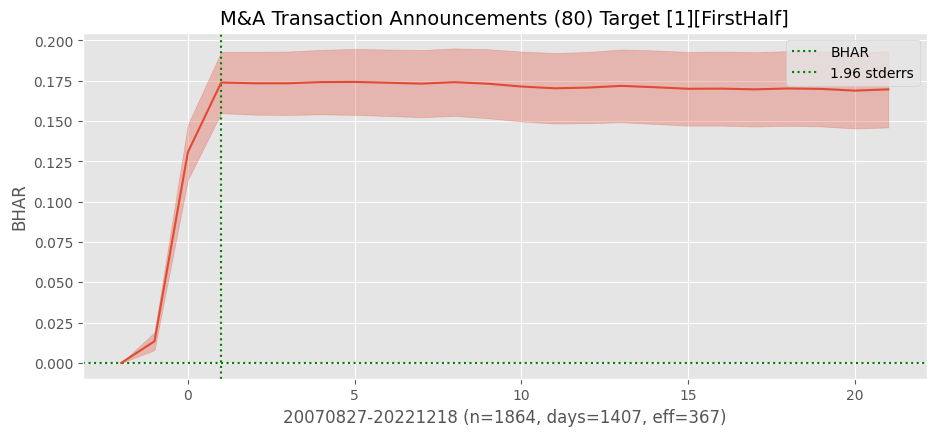

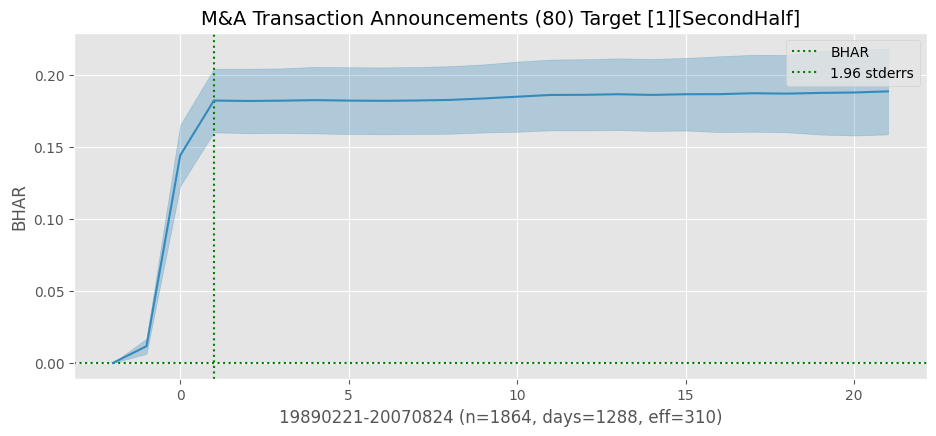

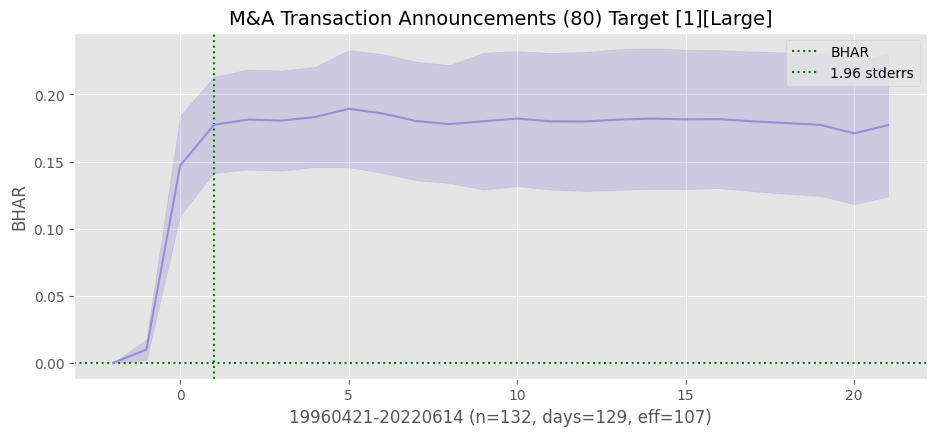

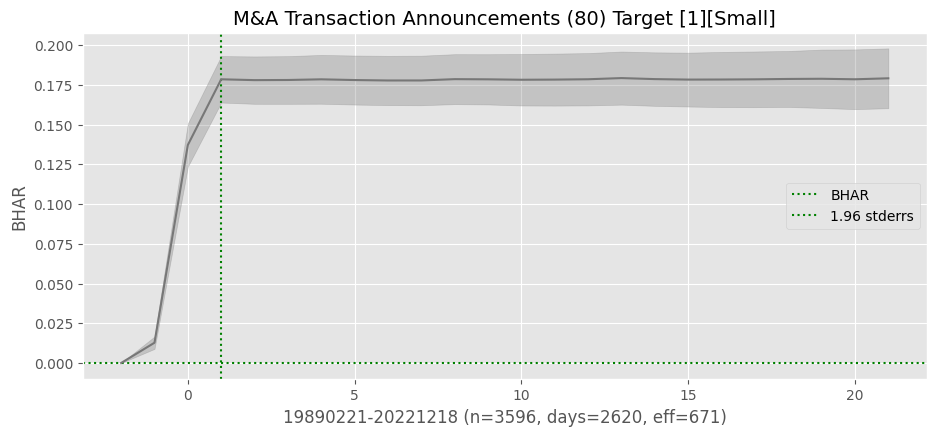

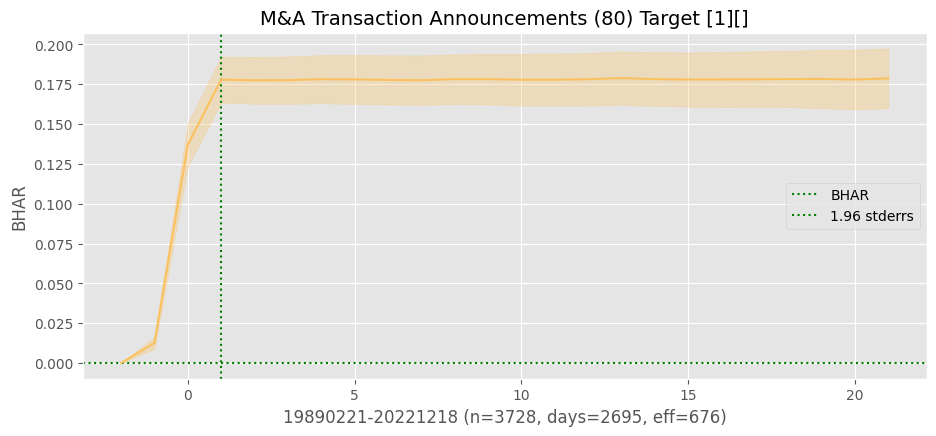

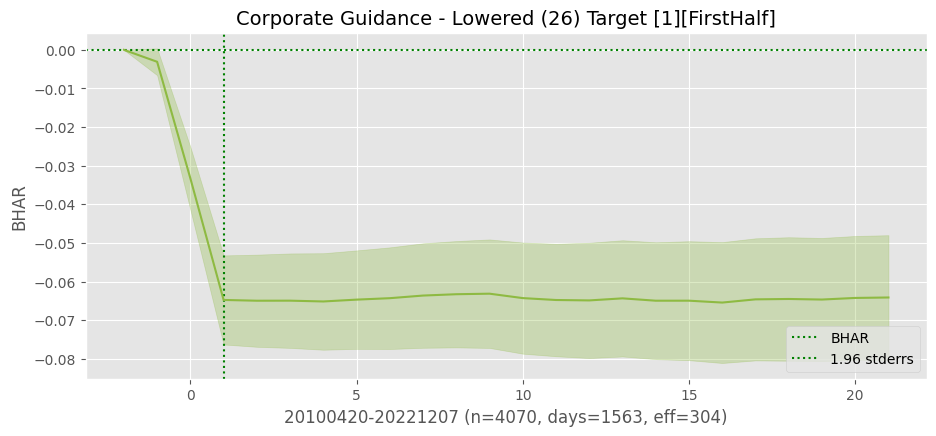

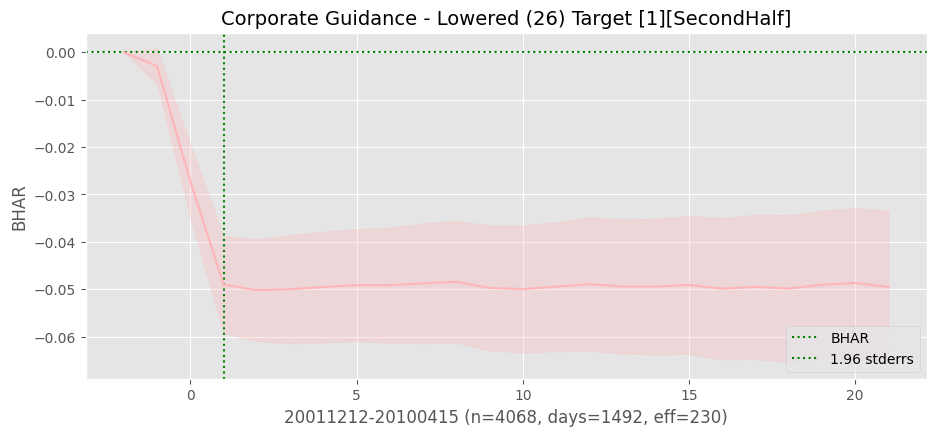

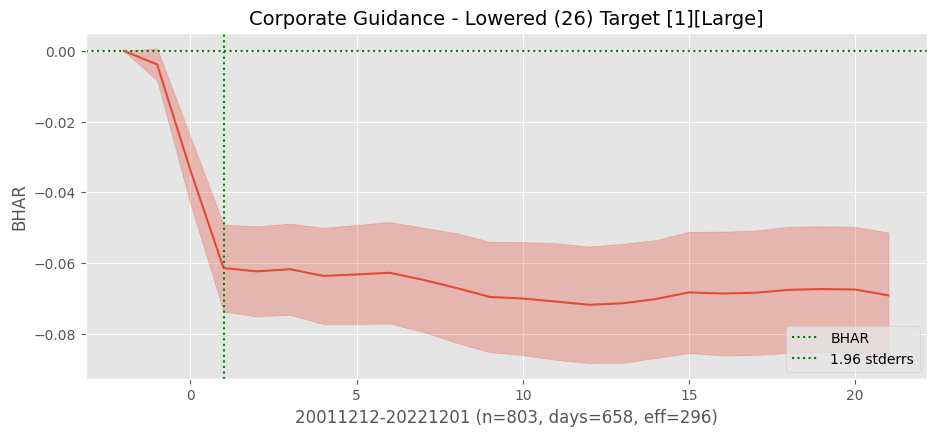

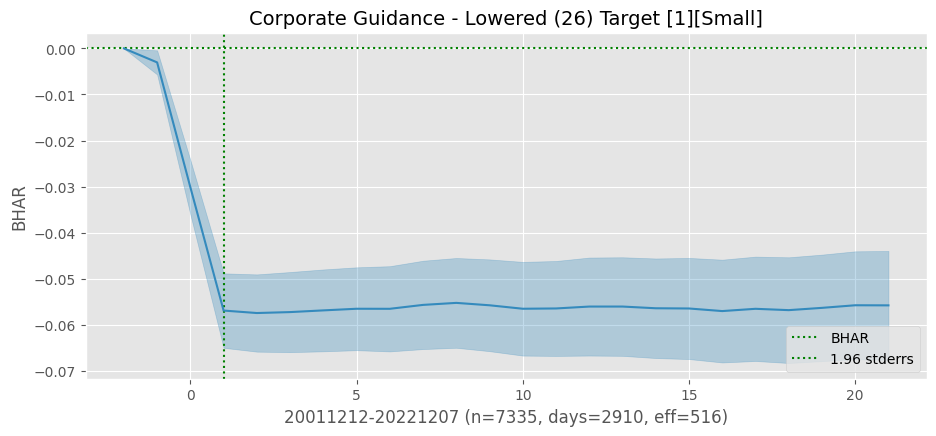

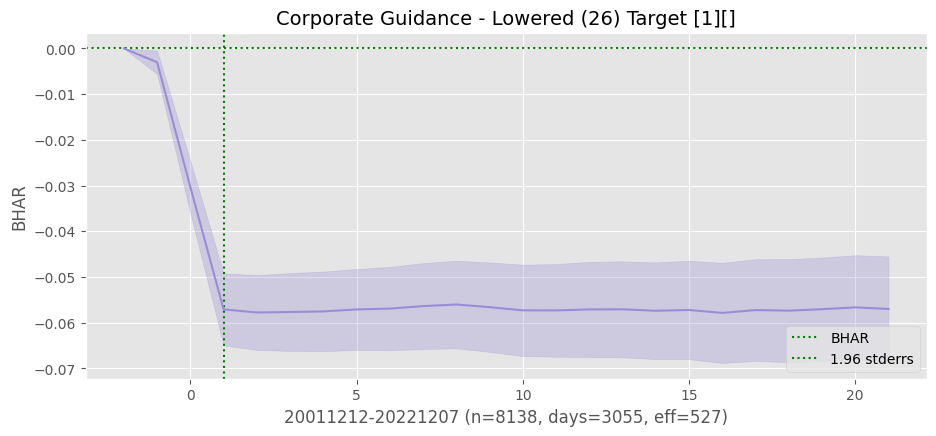

In [8]:
### Show by market cap and half-period
events_list = [[80,1], [26,1]]  # top announcement window
for i, (eventid, roleid) in enumerate(events_list):
    #eventid, roleid = 50, 1
    #eventid, roleid = 83, 1
    df = event_pipeline(eventstudy,
                        stocks=crsp,
                        eventid=eventid,
                        roleid=roleid,
                        beg=beg,
                        end=end,
                        left=left,
                        right=right,
                        post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'FirstHalf': df['announcedate'].ge(halfperiod).values,
              'SecondHalf': df['announcedate'].lt(halfperiod).values,
              'Large': df['cap'].ge(midcap).values,
              'Small': df['cap'].lt(midcap).values,
              '': []}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, figsize=(10, 5))
        bhar = eventstudy.fit(model='sbhar', rows=rows)
        eventstudy.plot(model='sbhar',
                        title=eventformat(eventid, roleid) + f"[{label}]",
                        drift=False,
                        ax=ax,
                        c=f"C{i*5+ifig}")
        plt.savefig(imgdir / (label + f"{eventid}_{roleid}.jpg"))

__Compute BHAR and CAR of all events__


In [9]:
restart = 0
for i, eventid in tqdm(enumerate(events)):
    if eventid <= restart:  # kludge to resume loop
        continue
    for roleid in roles:
        # retrieve all returns observations of this eventid, roleid
        df = event_pipeline(eventstudy,
                            stocks=crsp,
                            beg=beg,
                            end=end,
                            eventid=eventid,
                            roleid=roleid,
                            left=left,
                            right=right,
                            post=post)
        if df['announcedate'].nunique() < minobs:  # require min number of dates
            continue

        # compute both BHAR and CAR averages, then plot and save
        bhar = eventstudy.fit(model='sbhar')
        car = eventstudy.fit(model='scar')
        #eventstudy.write()
        eventstudy.write_summary()
        #print(eventstudy.label, eventid, roleid)
        show(DataFrame.from_dict(car | bhar, orient='index'))

        fig, axes = plt.subplots(2, 1, clear=True, figsize=(5, 5), num=1)
        eventstudy.plot(model='sbhar', ax=axes[0], title=eventstudy.label,
                        fontsize=8, vline=[right])
        eventstudy.plot(model='scar', ax=axes[1], title='',
                        fontsize=8, vline=[right])
        plt.savefig(imgdir / f"{eventid}_{roleid}.jpg")

33it [11:47:02, 1289.68s/it]

__Summarize BHAR's of all events__


In [ ]:
# sorted by 3-day event window abnormal returns
df = eventstudy.read_summary(model='sbhar')\
               .set_index('label')\
               .drop(columns=['rho', 'tau', 'created'])\
               .sort_values('window', ascending=False)

In [ ]:
# convert (eventid, roleid) to multiindex
df = df[df['days'] > 500].sort_values('post_t')
multiIndex = DataFrame(df.index.str.split('_').to_list()).astype(int)
df.index = pd.MultiIndex.from_frame(multiIndex, names=['eventid', 'roleid'])

In [ ]:
# show summary
df['event'] = keydev._event[df.index.get_level_values(0)].values
df['role'] = keydev._role[df.index.get_level_values(1)].values
show(df.set_index(['event', 'role']).drop(columns=['model']),
     caption="Post-Announcement Drift")

# Multiple Testing

In [ ]:
### Show actual two-sided p-values vs expected (with continuity correction)
pvals = list(norm.cdf(-df['post_t'].abs()) * 2)
argmin = np.argmin(pvals)
header = df.iloc[argmin][['event', 'role', 'days', 'effective', 'post_t']]\
           .to_dict()
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 9))
ax.plot(sorted(pvals))
ax.plot([0, len(pvals)-1], [0.5/len(pvals), (len(pvals)-0.5)/len(pvals)], 'r--')
ax.set_title('Distribution of p-values')
ax.legend(['actual', 'expected'])
plt.tight_layout()
plt.savefig(imgdir / 'pvals.jpg')

In [ ]:
### Bonferroni, Holm and Benjamin-Hochberg methods
alpha = 0.05
results = {}
for method in ['bonferroni', 'holm', 'fdr_bh']:
    tests =  multipletests(pvals, alpha=alpha, method=method)
    results[method] = header | {f'pval(alpha={alpha})': pvals[argmin],
                                'adj-pval': tests[1][argmin]}
show(DataFrame.from_dict(results, orient='index'),
     caption="Multiple Testing methods")